In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from itertools import product

## **Processing of the dataset**

In [145]:
%run dataset.py

[*********************100%***********************]  1 of 1 completed

S&P 500 data processed with RDP.
Data saved as 'processed_data_rdp_net.csv'.


In [146]:
data = pd.read_csv('data/processed_data_rdp_log.csv', index_col=0)
data.head()

,Close,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,,
2005-02-01,1189.410034,9.251176,1.781354,-0.550850,-0.070595,-1.059594,1.480793
2005-02-02,1193.189941,11.402198,1.615404,0.719985,0.858522,0.431699,0.686745
2005-02-03,1189.890015,7.089487,1.297574,1.224383,0.184226,0.518197,0.642527
2005-02-04,1203.030029,17.700814,2.667794,2.966183,2.149236,1.266476,0.414279
2005-02-07,1201.719971,14.341911,1.716369,3.210629,1.441619,1.300740,0.390989


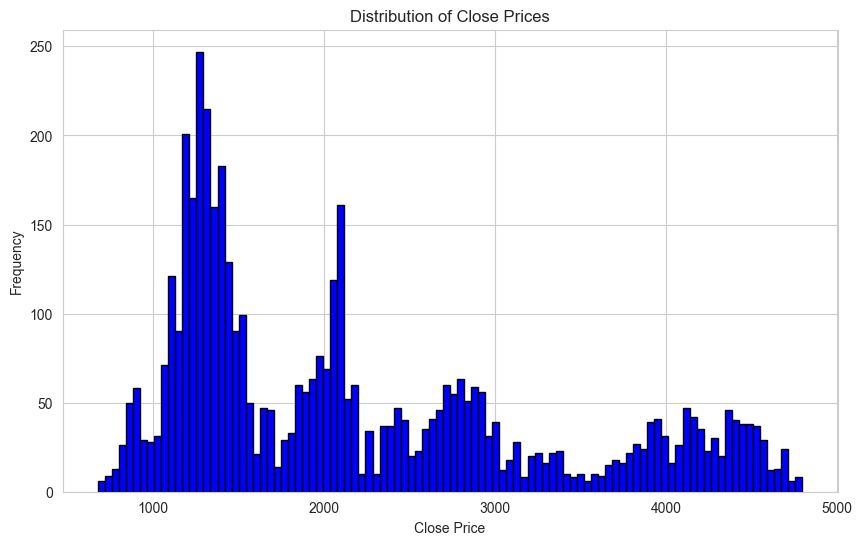

In [147]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

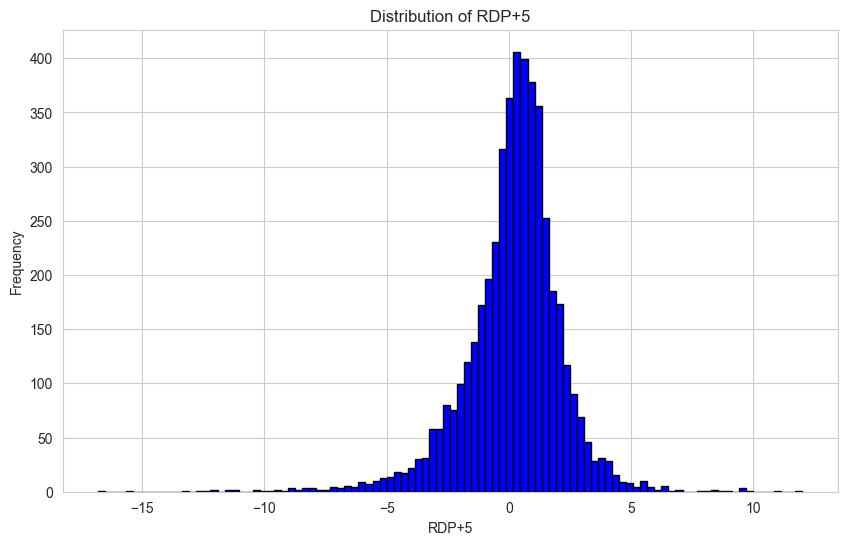

In [148]:
plt.figure(figsize=(10, 6))
plt.hist(data['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

### **Outliers**

In [149]:
def handle_outliers(dataframe, columns):
    """
    Replace outliers in specified columns with the closest marginal value.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to process.
    - columns (list): List of column names to apply outlier handling.
    
    Returns:
    - pd.DataFrame: DataFrame with outliers replaced.
    """
    for col in columns:
        mean = dataframe[col].mean()
        std_dev = dataframe[col].std()
        upper_limit = mean + 2 * std_dev
        lower_limit = mean - 2 * std_dev
        
        dataframe[col] = np.where(dataframe[col] > upper_limit, upper_limit, dataframe[col])
        dataframe[col] = np.where(dataframe[col] < lower_limit, lower_limit, dataframe[col])
    
    return dataframe

def scale_columns(dataframe, columns):
    """
    Scale the specified columns of a DataFrame to the range [-0.9, 0.9].

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names to scale.

    Returns:
    - pd.DataFrame: DataFrame with scaled columns.
    """
    scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
    dataframe[columns] = scaler.fit_transform(dataframe[columns])
    return dataframe

In [150]:
data_scaled = handle_outliers(data, columns=['RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = scale_columns(data_scaled, columns=['EMA15','RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = data_scaled.drop(columns=['Close'])
print(data_scaled.shape)
data_scaled.head()

(4756, 6)


,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,
2005-02-01,0.427594,0.298403,-0.112744,-0.055107,-0.156395,0.288841
2005-02-02,0.433592,0.268111,0.057408,0.046517,-0.013660,0.114253
2005-02-03,0.421567,0.210095,0.124942,-0.027235,-0.005381,0.104530
2005-02-04,0.451154,0.460212,0.358151,0.187691,0.066239,0.054345
2005-02-07,0.441788,0.286541,0.390880,0.110294,0.069518,0.049224


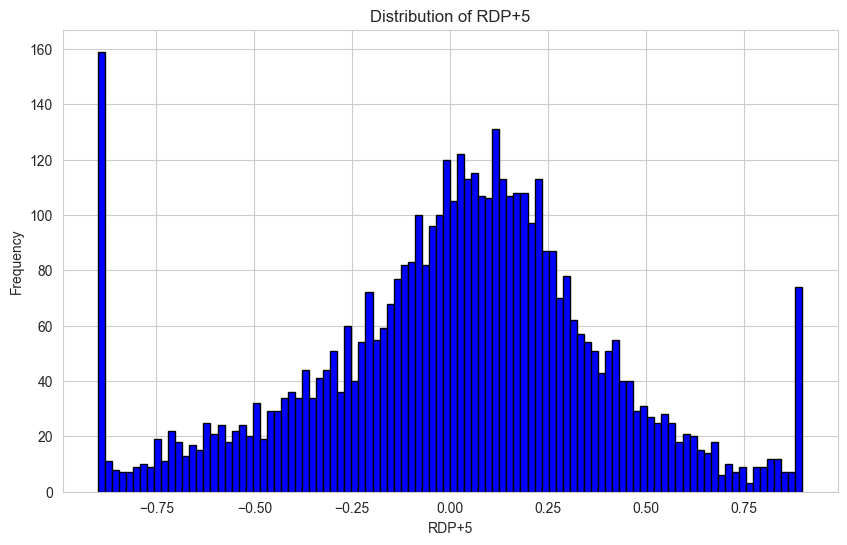

In [151]:
plt.figure(figsize=(10, 6))
plt.hist(data_scaled['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

## Splitting the data into Training-Validation-Testing

In [152]:
def split_data(dataframe, train_ratio=0.7, val_ratio=0.15):
    """
    Split the data into training, validation, and testing sets.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame to split.
    - train_ratio (float): Proportion of data for training (default: 0.7).
    - val_ratio (float): Proportion of data for validation (default: 0.15).

    Returns:
    - tuple: (train_data, val_data, test_data)
    """
    train_end = int(len(dataframe) * train_ratio)
    val_end = train_end + int(len(dataframe) * val_ratio)

    train_data = dataframe[:train_end]
    val_data = dataframe[train_end:val_end]
    test_data = dataframe[val_end:]

    return train_data, val_data, test_data

In [153]:
train_data, val_data, test_data = split_data(data_scaled)

print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Testing data: {test_data.shape}')

Training data: (3329, 6)
Validation data: (713, 6)
Testing data: (714, 6)


In [154]:
features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']
target = 'RDP+5'

## **SVM Regression Model**

In [155]:
# SVM Regression Training and Evaluation
def train_and_evaluate_svm(train_data, val_data, test_data, features, target):
    """
    Train and evaluate an SVM regression model on the given data.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.

    Returns:
    - dict: A dictionary containing the model, predictions, and evaluation metrics.
    """
    # Prepare training, validation, and testing data
    X_train = train_data[features]
    y_train = train_data[target]

    X_val = val_data[features]
    y_val = val_data[target]

    X_test = test_data[features]
    y_test = test_data[target]

    # Train the SVR model
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)

    # Validate the model
    val_predictions = svr.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_nmse = val_mse / np.var(y_val)
    val_r2 = r2_score(y_val, val_predictions)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation NMSE: {val_nmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Test the model
    test_predictions = svr.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)
    test_r2 = r2_score(y_test, test_predictions)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test NMSE: {test_nmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Return results
    return {
        "model": svr,
        "val_predictions": val_predictions,
        "test_predictions": test_predictions,
        "y_test": y_test,
        "validation_metrics": {"mse": val_mse, "r2": val_r2, "nmse": val_nmse},
        "test_metrics": {"mse": test_mse, "r2": test_r2, "nmse": test_nmse},
    }

# Plot Predictions vs Actual Values
def plot_predictions(y_test, test_predictions, name_model,start_idx=0, end_idx=100):
    """
    Plot predictions vs actual values for a specified range.

    Parameters:
    - y_test (pd.Series): Actual target values from the test set.
    - test_predictions (np.ndarray): Predicted target values from the test set.
    - start_idx (int): Starting index for the range to plot.
    - end_idx (int): Ending index for the range to plot.
    """
    index = np.arange(abs(start_idx - end_idx))
    plt.figure(figsize=(10, 6))
    plt.plot(index, y_test.values[start_idx:end_idx], label='Actual Values', color='blue')
    plt.plot(index, test_predictions[start_idx:end_idx], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'{name_model}: Predicted vs Actual')
    plt.xlabel('Index')
    plt.ylabel('RDP+5')
    plt.legend()
    plt.show()

Validation MSE: 0.1589
Validation NMSE: 0.9932
Validation R²: 0.0068
Test MSE: 0.1827
Test NMSE: 1.0521
Test R²: -0.0521


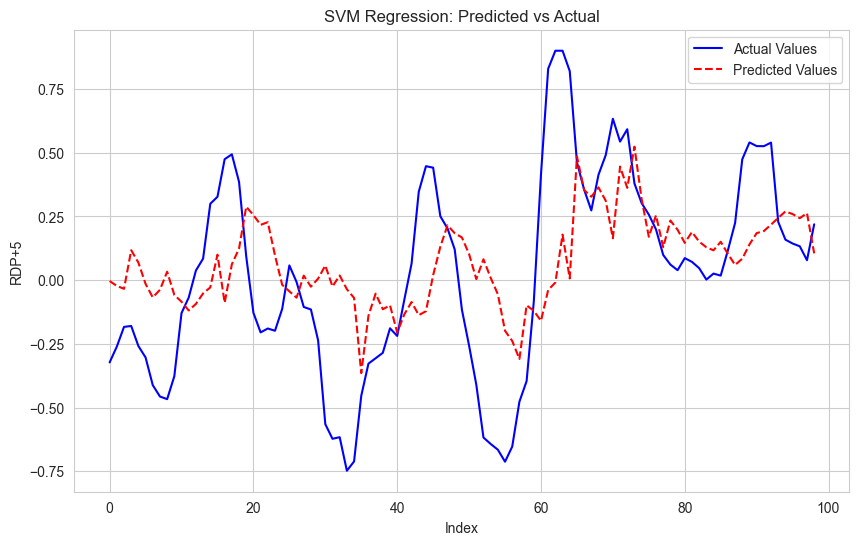

In [156]:
svr_results = train_and_evaluate_svm(train_data, val_data, test_data, features, target)
plot_predictions(svr_results['y_test'], svr_results['test_predictions'],name_model = "SVM Regression", start_idx=-100, end_idx=-1)

### **Optimisation of the Hyper-parameters**

In [157]:
from sklearn.model_selection import GridSearchCV

def optimize_svm(train_data, val_data, features, target, param_grid):
    """
    Optimize the SVM hyperparameters using GridSearchCV.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary specifying hyperparameter ranges for GridSearchCV.

    Returns:
    - dict: Best hyperparameters and the optimized model.
    """
    # Combine training and validation sets for optimization
    combined_data = pd.concat([train_data, val_data])
    X_combined = combined_data[features]
    y_combined = combined_data[target]

    # Initialize the SVR model
    svr = SVR(kernel='rbf')

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all available cores
    )

    # Perform the grid search
    grid_search.fit(X_combined, y_combined)

    # Extract the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best hyperparameters: {best_params}")

    # Train the final model using the best hyperparameters
    best_model = grid_search.best_estimator_

    return {
        "best_model": best_model,
        "best_params": best_params,
        "grid_search": grid_search
    }

In [158]:
def optimize_svr_nmse(train_data, val_data, features, target, param_grid):
    """
    Optimize the SVR hyperparameters using custom NMSE-based scoring.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary containing hyperparameter ranges for 'C', 'epsilon', and 'gamma'.

    Returns:
    - dict: Best SVR model, hyperparameters, and evaluation metrics.
    """
    # Extract hyperparameter ranges from param_grid
    C_values = param_grid.get("C", [1.0])
    epsilon_values = param_grid.get("epsilon", [0.1])
    gamma_values = param_grid.get("gamma", ["scale"])

    # Prepare training and validation data
    X_train = train_data[features].values
    y_train = train_data[target].values
    X_val = val_data[features].values
    y_val = val_data[target].values

    best_nmse = float('inf')
    best_params = None
    best_model = None

    # Iterate through all hyperparameter combinations
    for C, epsilon, gamma in product(C_values, epsilon_values, gamma_values):
        try:
            print(f"Evaluating SVR(C={C}, epsilon={epsilon}, gamma={gamma})...")
            model = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma)
            model.fit(X_train, y_train)
            val_predictions = model.predict(X_val)

            # Calculate NMSE
            mse = mean_squared_error(y_val, val_predictions)
            nmse = mse / np.var(y_val)

            print(f"NMSE: {nmse:.4f}")

            if nmse < best_nmse:
                best_nmse = nmse
                best_params = {"C": C, "epsilon": epsilon, "gamma": gamma}
                best_model = model

        except Exception as e:
            print(f"SVR(C={C}, epsilon={epsilon}, gamma={gamma}) failed: {e}")

    val_predictions = best_model.predict(X_val)
    mse = mean_squared_error(y_val, val_predictions)
    r2 = r2_score(y_val, val_predictions)
    
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best NMSE: {best_nmse:.4f}")
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R²: {r2:.4f}")

    return {
        "best_model": best_model,
        "best_params": best_params,
        "best_nmse": best_nmse,
        "mse": mse,
        "r2": r2
    }

In [159]:
# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.1, 1, 10],
    "epsilon": [0.001, 0.01, 0.1],
    "gamma": [0.001 ,0.01, 0.1, 1]
}
# Optimize hyperparameters
optimization_results = optimize_svr_nmse(train_data, val_data, features, target, param_grid)

# Evaluate the best model on the test set
best_model = optimization_results["best_model"]
X_test = test_data[features]
y_test = test_data[target]
# Test the model
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test NMSE: {test_nmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.001)...
NMSE: 1.0012
Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.01)...
NMSE: 0.9997
Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.1)...
NMSE: 0.9925
Evaluating SVR(C=0.001, epsilon=0.001, gamma=1)...
NMSE: 0.9861
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.001)...
NMSE: 1.0010
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.01)...
NMSE: 0.9995
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.1)...
NMSE: 0.9923
Evaluating SVR(C=0.001, epsilon=0.01, gamma=1)...
NMSE: 0.9863
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.001)...
NMSE: 1.0014
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.01)...
NMSE: 0.9999
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.1)...
NMSE: 0.9932
Evaluating SVR(C=0.001, epsilon=0.1, gamma=1)...
NMSE: 0.9874
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.001)...
NMSE: 0.9909
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.01)...
NMSE: 0.9781
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.1)...
NMSE: 0.9667
Evaluating SVR(C=0.1, 

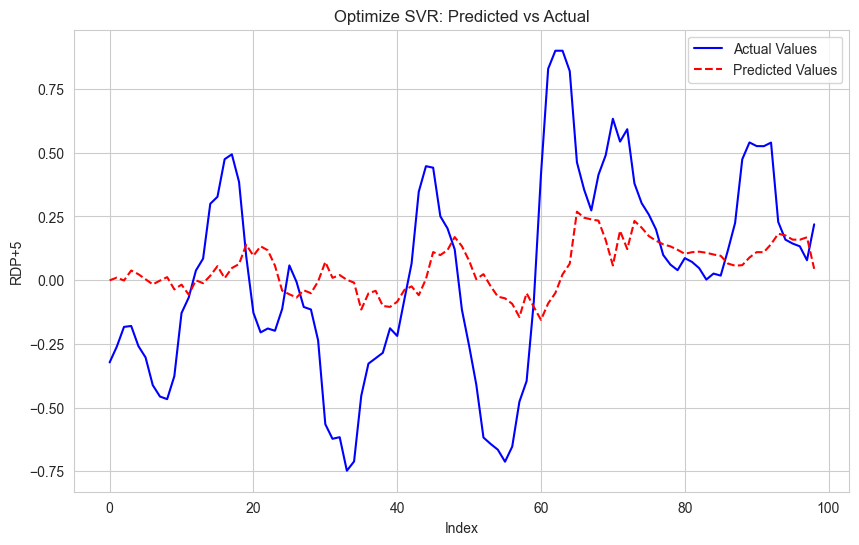

In [160]:
# Plot predictions for a specific range (e.g., last 100 data points)
plot_predictions(y_test, test_predictions, name_model="Optimize SVR",start_idx=-100, end_idx=-1)

## **Financial Time series (ARIMA/ARIMAX)**

In [161]:
import warnings
warnings.filterwarnings("ignore")  # Suppress ARIMA warnings during grid search

In [162]:
def run_arima(train_data, test_data, order=(1, 1, 1)):
    """
    Fit and evaluate an ARIMA model.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - target (str): Name of the target column.
    - order (tuple): ARIMA model order (p, d, q).

    Returns:
    - dict: ARIMA model, predictions, and evaluation metrics.
    """
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    model_fitted = model.fit()

    # Predict on the test set
    predictions = model_fitted.forecast(steps=len(test_data))

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)

    print(f"ARIMA ({order}) Test MSE: {mse:.4f}")
    print(f"ARIMA ({order}) Test R²: {r2:.4f}")

    return {
        "model": model_fitted,
        "predictions": predictions,
        "mse": mse,
        "r2": r2
    }

# ARIMAX Model
def run_arimax(train_data, test_data, exog_train, exog_test, order=(1, 1, 1)):
    """
    Fit and evaluate an ARIMAX model.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - exog_test (pd.DataFrame): Exogenous variables for testing.
    - target (str): Name of the target column.
    - order (tuple): ARIMAX model order (p, d, q).

    Returns:
    - dict: ARIMAX model, predictions, and evaluation metrics.
    """
    # Fit ARIMAX model
    model = SARIMAX(train_data, exog=exog_train, order=order)
    model_fitted = model.fit()

    # Predict on the test set
    predictions = model_fitted.forecast(steps=len(test_data), exog=exog_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)
    nmse = mse / np.var(test_data)

    print(f"ARIMAX ({order}) Test MSE: {mse:.4f}")
    print(f"ARIMAX ({order}) Test R²: {r2:.4f}")
    print(f"ARIMAX ({order}) Test NMSE: {nmse:.4f}")

    return {
        "model": model_fitted,
        "predictions": predictions,
        "mse": mse,
        "r2": r2,
        "nmse": nmse
    }

In [163]:
# Define target and exogenous features
target = 'RDP+5'
exogenous_features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']

# Split data
y_train = train_data[target]
y_val = val_data[target]
y_test = test_data[target]

X_train = train_data[exogenous_features]
X_val = val_data[exogenous_features]
X_test = test_data[exogenous_features]

ARIMA ((1, 1, 1)) Test MSE: 0.2280
ARIMA ((1, 1, 1)) Test R²: -0.3130


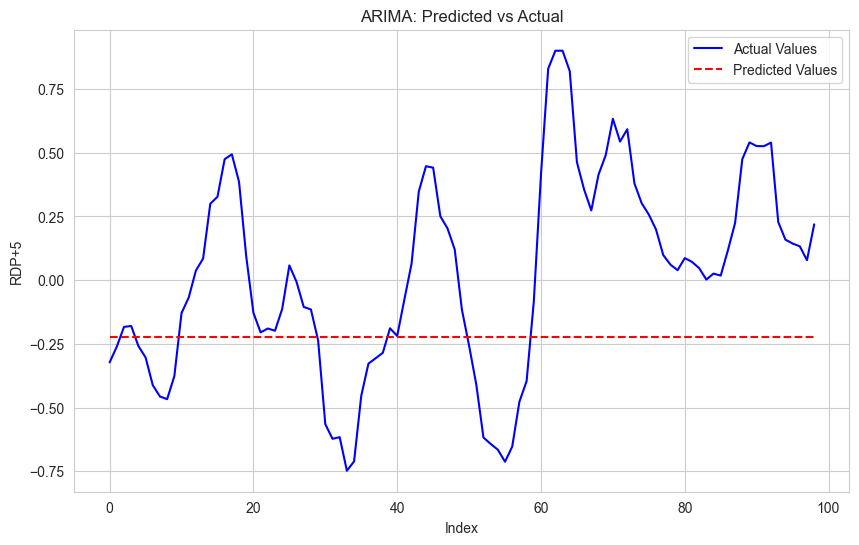

In [164]:
# Run ARIMA
arima_results = run_arima(y_train, y_test, order=(1, 1, 1))
arima_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arima_results['predictions'], name_model = "ARIMA", start_idx=-100, end_idx=-1)

ARIMAX ((1, 1, 1)) Test MSE: 0.3919
ARIMAX ((1, 1, 1)) Test R²: -1.2567
ARIMAX ((1, 1, 1)) Test NMSE: 2.2567


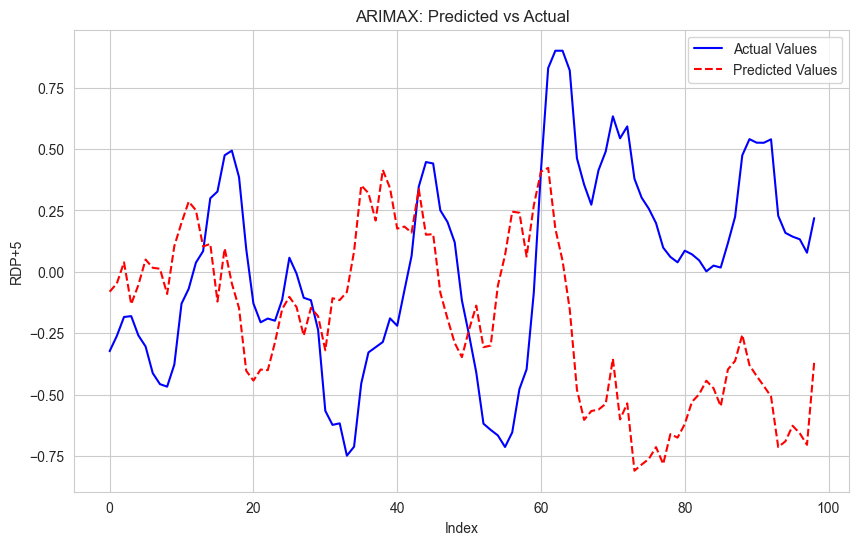

In [165]:
# Run ARIMAX
arimax_results = run_arimax(y_train, y_test, X_train, X_test, order=(1, 1, 1))
arimax_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arimax_results['predictions'], name_model = "ARIMAX", start_idx=-100, end_idx=-1)

In [166]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def optimize_arimax(train_data, exog_train, val_data, exog_val, param_grid_arimax):
    """
    Optimize the ARIMAX model using a validation set and a parameter grid for hyperparameter tuning.

    Parameters:
    - train_data (pd.Series): Training target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - val_data (pd.Series): Validation target data.
    - exog_val (pd.DataFrame): Exogenous variables for validation.
    - param_grid_arimax (dict): Dictionary with lists of 'p_values', 'd_values', and 'q_values'.

    Returns:
    - dict: Best ARIMAX model, its parameters, and evaluation metrics.
    """
    # Extract p, d, q values from the parameter grid
    p_values = param_grid_arimax.get("p_values", [0])
    d_values = param_grid_arimax.get("d_values", [0])
    q_values = param_grid_arimax.get("q_values", [0])

    best_nmse = float('inf')
    best_order = None
    best_model = None
    best_mse = None
    best_r2 = None

    # Iterate through all combinations of p, d, q
    for (p, d, q) in product(p_values, d_values, q_values):
        try:
            print(f"Evaluating ARIMAX({p},{d},{q})...")
            model = SARIMAX(train_data, exog=exog_train, order=(p, d, q))
            model_fitted = model.fit(disp=False)
            predictions = model_fitted.forecast(steps=len(val_data), exog=exog_val)

            # Calculate metrics
            mse = mean_squared_error(val_data, predictions)
            nmse = mse / np.var(val_data)
            r2 = r2_score(val_data, predictions)
            
            print(f'nmse: {nmse}')

            # Update best model if current one is better
            if nmse < best_nmse:
                best_nmse = nmse
                best_order = (p, d, q)
                best_model = model_fitted
                best_mse = mse
                best_r2 = r2

        except Exception as e:
            print(f"ARIMAX({p},{d},{q}) failed: {e}")

    print(f"Best ARIMAX Order: {best_order} with Validation NMSE: {best_nmse:.4f}")

    return {
        "best_model": best_model,
        "best_order": best_order,
        "nmse": best_nmse,
        "mse": best_mse,
        "r2": best_r2
    }


In [167]:
# Optimize ARIMAX
param_grid_arimax = {
        "p_values": [1, 2, 3],
        "d_values": [0, 1],
        "q_values": [1, 2, 3]
    }

amimax_optimized_results = optimize_arimax(y_train, X_train, y_val, X_val, param_grid_arimax)

# Evaluate the final model on the test set
best_model = amimax_optimized_results['best_model']
test_predictions = best_model.forecast(steps=len(y_test), exog=X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test NMSE: {test_nmse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

Evaluating ARIMAX(1,0,1)...
nmse: 3.3869381179776585
Evaluating ARIMAX(1,0,2)...
nmse: 3.047620275423316
Evaluating ARIMAX(1,0,3)...
nmse: 2.9991313786610974
Evaluating ARIMAX(1,1,1)...
nmse: 2.33480628423728
Evaluating ARIMAX(1,1,2)...
nmse: 2.028670734358653
Evaluating ARIMAX(1,1,3)...
nmse: 1.8768038636996975
Evaluating ARIMAX(2,0,1)...
nmse: 2.464932567958115
Evaluating ARIMAX(2,0,2)...
nmse: 2.5206475246338482
Evaluating ARIMAX(2,0,3)...
nmse: 2.206555466565864
Evaluating ARIMAX(2,1,1)...
nmse: 2.3016814786349244
Evaluating ARIMAX(2,1,2)...
nmse: 2.3368240532214726
Evaluating ARIMAX(2,1,3)...
nmse: 2.323425223961395
Evaluating ARIMAX(3,0,1)...
nmse: 2.470663080209091
Evaluating ARIMAX(3,0,2)...
nmse: 3.4437160820456207
Evaluating ARIMAX(3,0,3)...
nmse: 2.4615528788754775
Evaluating ARIMAX(3,1,1)...
nmse: 2.061167452892425
Evaluating ARIMAX(3,1,2)...
nmse: 1.8549097205033105
Evaluating ARIMAX(3,1,3)...
nmse: 2.249078708966134
Best ARIMAX Order: (3, 1, 2) with Validation NMSE: 1.854

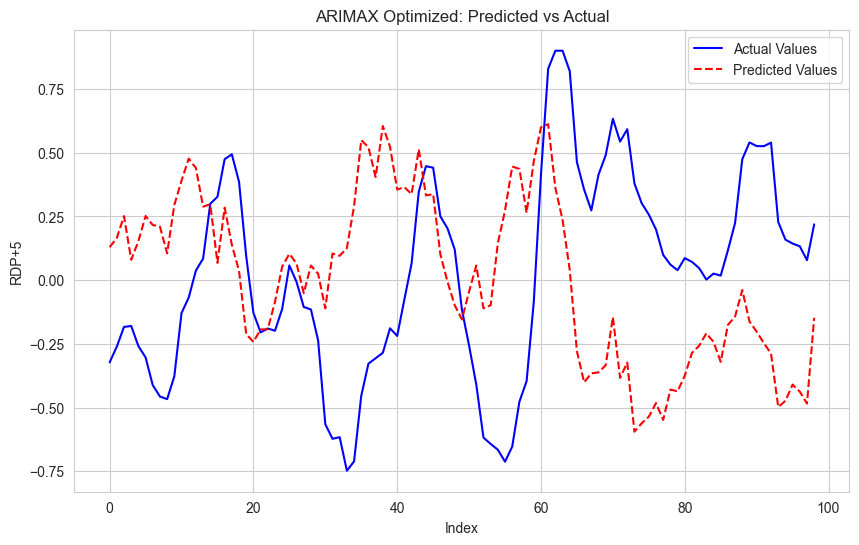

In [168]:
plot_predictions(y_test, amimax_optimized_results['best_model'].forecast(steps=len(test_data), exog=X_test), name_model = "ARIMAX Optimized", start_idx=-100, end_idx=-1)

## **Backpropagation (Neural Network)**

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
import tensorflow as tf

# Define NMSE metric
def nmse_metric(y_true, y_pred):
    """
    Custom metric to calculate Normalized Mean Squared Error (NMSE).
    
    NMSE = MSE / Variance(y_true)
    """
    mse = K.mean(K.square(y_true - y_pred))
    var = K.var(y_true)
    return mse / var

In [178]:
def run_backpropagation(train_data, val_data, test_data, features, target, epochs=50, batch_size=32, show_plots=False):
    """
    Fit and evaluate a Backpropagation neural network model.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - epochs (int): Number of epochs for training.
    - batch_size (int): Batch size for training.
    - show_plots (bool): Whether to display loss plots for training and validation.

    Returns:
    - dict: Neural network model, predictions, and evaluation metrics.
    """
    import tensorflow.keras.backend as K

    # Prepare training, validation, and testing data
    X_train = train_data[features].values
    y_train = train_data[target].values

    X_val = val_data[features].values
    y_val = val_data[target].values

    X_test = test_data[features].values
    y_test = test_data[target].values

    # Normalize the features
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Custom NMSE loss function
    def nmse_metric(y_true, y_pred):
        """
        Custom metric to calculate Normalized Mean Squared Error (NMSE).
        
        NMSE = MSE / Variance(y_true)
        """
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        var = tf.math.reduce_variance(y_true)
        nmse = tf.cond(tf.equal(var, 0), lambda: tf.constant(0.0), lambda: mse / var)
        
        return nmse

    # Build the model
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss=nmse_metric, metrics=['mse'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Plot the training and validation loss if show_plots is True
    if show_plots:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training NMSE Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation NMSE Loss', color='orange')
        plt.title('Training and Validation NMSE Loss')
        plt.xlabel('Epochs')
        plt.ylabel('NMSE Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Validation predictions and metrics
    predictions = model.predict(X_val).flatten()
    mse = mean_squared_error(y_val, predictions)
    nmse = mse / np.var(y_val)
    print(f'nmse: {nmse}')

    # Evaluate on the test set
    test_predictions = model.predict(X_test).flatten()
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)

    print(f"Backpropagation Test MSE: {test_mse:.4f}")
    print(f"Backpropagation Test R²: {test_r2:.4f}")
    print(f"Backpropagation Test NMSE: {test_nmse:.4f}")

    return {
        "model": model,
        "history": history,
        "predictions": test_predictions,
        "mse": test_mse,
        "r2": test_r2,
        "nmse": test_nmse
    }


Epoch 1/50
105/105 - 3s - 29ms/step - loss: 1.0572 - mse: 0.1362 - val_loss: 1.1863 - val_mse: 0.1566
Epoch 2/50
105/105 - 0s - 3ms/step - loss: 1.0421 - mse: 0.1334 - val_loss: 1.2734 - val_mse: 0.1587
Epoch 3/50
105/105 - 0s - 3ms/step - loss: 1.0325 - mse: 0.1326 - val_loss: 1.4081 - val_mse: 0.1649
Epoch 4/50
105/105 - 0s - 2ms/step - loss: 1.0179 - mse: 0.1318 - val_loss: 1.2844 - val_mse: 0.1572
Epoch 5/50
105/105 - 0s - 2ms/step - loss: 1.0303 - mse: 0.1316 - val_loss: 1.2200 - val_mse: 0.1557
Epoch 6/50
105/105 - 0s - 2ms/step - loss: 1.0074 - mse: 0.1301 - val_loss: 1.2282 - val_mse: 0.1542
Epoch 7/50
105/105 - 0s - 2ms/step - loss: 1.0071 - mse: 0.1299 - val_loss: 1.3412 - val_mse: 0.1602
Epoch 8/50
105/105 - 0s - 2ms/step - loss: 1.0109 - mse: 0.1303 - val_loss: 1.1979 - val_mse: 0.1528
Epoch 9/50
105/105 - 0s - 2ms/step - loss: 1.0218 - mse: 0.1308 - val_loss: 1.2970 - val_mse: 0.1576
Epoch 10/50
105/105 - 0s - 2ms/step - loss: 1.0011 - mse: 0.1297 - val_loss: 1.2071 - val_

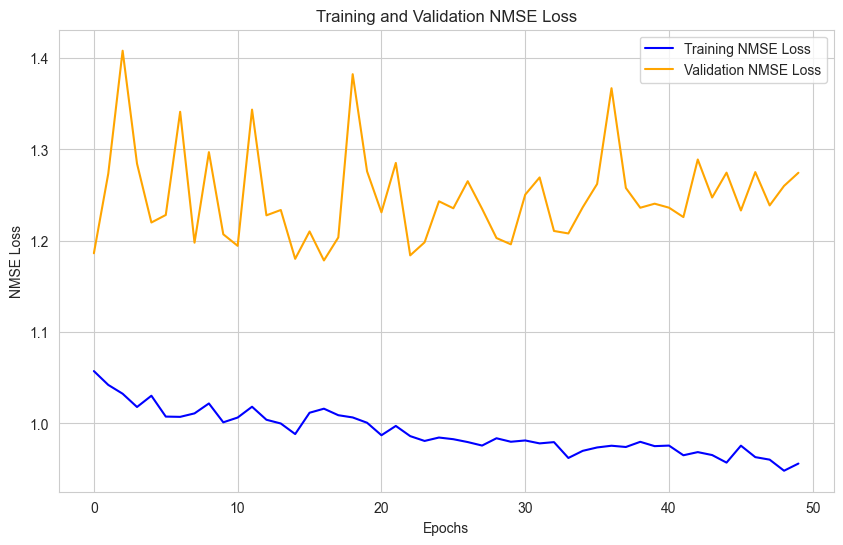

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
nmse: 1.036298306662517
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Backpropagation Test MSE: 0.1744
Backpropagation Test R²: -0.0043
Backpropagation Test NMSE: 1.0043


In [179]:
# Run Backpropagation
backprop_results = run_backpropagation(train_data, val_data, test_data, features, target, epochs=50, batch_size=32, show_plots=True)

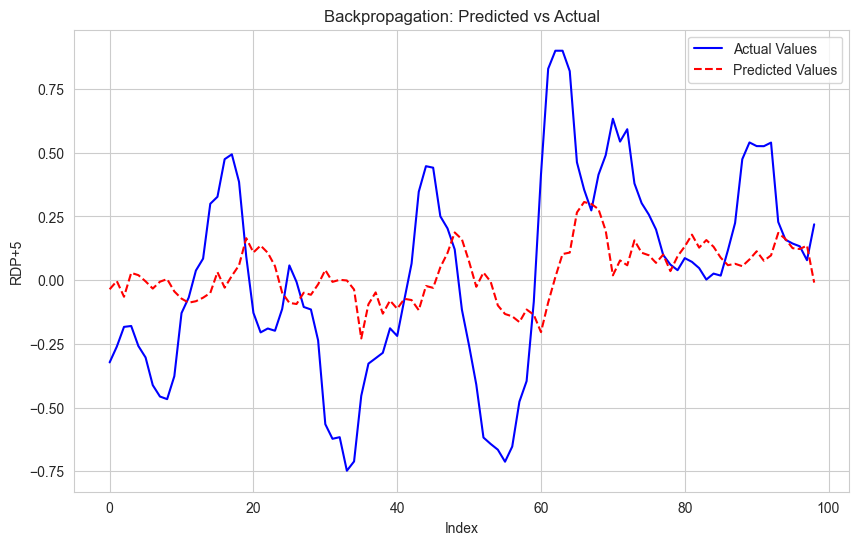

In [180]:
plot_predictions(y_test,backprop_results['predictions'], name_model = "Backpropagation", start_idx=-100, end_idx=-1)

In [173]:
def optimize_backpropagation(train_data, val_data, test_data, features, target, param_grid):
    """
    Optimize the Backpropagation Neural Network using a validation set and a parameter grid.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary with lists of hyperparameters to tune:
        - 'hidden_layers': List of tuples defining the number of neurons per layer (e.g., [(64, 32), (128, 64, 32)]).
        - 'batch_size': List of batch sizes to test (e.g., [16, 32, 64]).
        - 'learning_rate': List of learning rates to test (e.g., [0.001, 0.01, 0.1]).
        - 'epochs': List of numbers of epochs (e.g., [50, 100]).

    Returns:
    - dict: Best model, its parameters, and evaluation metrics.
    """
    # Extract hyperparameters from the grid
    hidden_layers_list = param_grid.get("hidden_layers", [(64, 32)])
    batch_sizes = param_grid.get("batch_size", [32])
    learning_rates = param_grid.get("learning_rate", [0.001])
    epochs_list = param_grid.get("epochs", [50])

    best_nmse = float('inf')
    best_params = None
    best_model = None
    best_mse = None
    best_r2 = None

    # Prepare data
    X_train = train_data[features].values
    y_train = train_data[target].values
    X_val = val_data[features].values
    y_val = val_data[target].values
    X_test = test_data[features].values
    y_test = test_data[target].values

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    def nmse_metric(y_true, y_pred):
        """
        Custom metric to calculate Normalized Mean Squared Error (NMSE).
        
        NMSE = MSE / Variance(y_true)
        """
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        var = tf.math.reduce_variance(y_true)
        nmse = tf.cond(tf.equal(var, 0), lambda: tf.constant(0.0), lambda: mse / var)
        
        # Debugging output
    
        return nmse

    # Iterate through all combinations of hyperparameters
    for hidden_layers, batch_size, learning_rate, epochs in product(
        hidden_layers_list, batch_sizes, learning_rates, epochs_list
    ):
        print(f'Evaluating bp: (hidden_layers:{hidden_layers}, batch_size:{batch_size}, learning_rate:{learning_rate}, epochs:{epochs}')
        try:

            # Build the model
            model = Sequential()
            model.add(Dense(hidden_layers[0], input_dim=X_train.shape[1], activation='relu'))
            for units in hidden_layers[1:]:
                model.add(Dense(units, activation='relu'))
            model.add(Dense(1, activation='linear'))

            # Compile the model
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss=nmse_metric)

            # Train the model
            model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )

            # Evaluate the model
            predictions = model.predict(X_val).flatten()
            mse = mean_squared_error(y_val, predictions)
            nmse = mse / np.var(y_val)
            r2 = r2_score(y_val, predictions)
            print(f'nmse: {nmse}')

            # Update best model if current one is better
            if nmse < best_nmse:
                best_nmse = nmse
                best_params = {
                    "hidden_layers": hidden_layers,
                    "batch_size": batch_size,
                    "learning_rate": learning_rate,
                    "epochs": epochs
                }
                best_model = model
                best_mse = mse
                best_r2 = r2

        except Exception as e:
            print(f"Model with layers={hidden_layers}, batch_size={batch_size}, "
                  f"learning_rate={learning_rate}, epochs={epochs} failed: {e}")

    print(f"Best Model Params: {best_params} with Validation NMSE: {best_nmse:.4f}")
    
    # Evaluate on the test set
    test_predictions = best_model.predict(X_test).flatten()
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test NMSE: {test_nmse:.4f}")

    return {
        "best_model": best_model,
        "best_params": best_params,
        "predictions": test_predictions,
        "validation_nmse": best_nmse,
        "validation_mse": best_mse,
        "validation_r2": best_r2,
        "mse": test_mse,
        "r2": test_r2,
        "nmse": test_nmse
    }

In [184]:
param_grid_bp = {
    "hidden_layers": [(64, 32), (128, 64)],
    "batch_size": [16, 32],
    "learning_rate": [0.001, 0.01],
    "epochs": [50, 100]
}
bp_optimized_results = optimize_backpropagation(train_data, val_data,test_data, features, target, param_grid_bp)

Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.001, epochs:50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
nmse: 0.9671392623732658
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.001, epochs:100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
nmse: 1.0204570450196098
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.01, epochs:50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
nmse: 0.9741663864472254
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.01, epochs:100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
nmse: 0.9967418437125145
Evaluating bp: (hidden_layers:(64, 32), batch_size:32, learning_rate:0.001, epochs:50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
nmse: 0.9845935783668588
Evaluating bp: (hidden_layers:(64, 32), batch_size:32, learning_rate:0.001, epochs:100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
nmse: 0.9787449554166804
Evaluating bp: (hidden_layers:(64, 32), batch_size:32, learning_rate:0.01, epochs:50
23/23 ━━━━━━

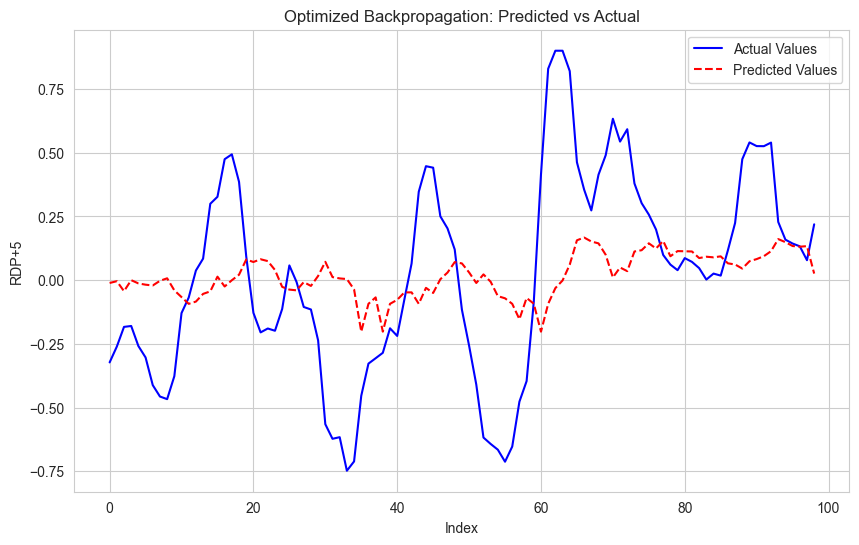

In [185]:
plot_predictions(y_test, bp_optimized_results['predictions'], name_model="Optimized Backpropagation", start_idx=-100, end_idx=-1)

## **Comparison of the models**

In [186]:
print("SVM Regression: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(svr_results['test_metrics']['mse'], svr_results['test_metrics']['r2'],svr_results['test_metrics']['nmse'] ))
print("Backpropagation opt: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(bp_optimized_results['mse'], bp_optimized_results['r2'], bp_optimized_results['nmse']))
print("ARIMAX: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(amimax_optimized_results['mse'], amimax_optimized_results['r2'], amimax_optimized_results['nmse']))

SVM Regression: MSE = 0.1827, R² = -0.0521, NMSE = 1.0521
Backpropagation opt: MSE = 0.1741, R² = -0.0024, NMSE = 1.0024
ARIMAX: MSE = 0.2968, R² = -0.8549, NMSE = 1.8549
